In [1]:
import math
import re

import matplotlib.pyplot as plt
import pandas as pd

from attributes.individual.migration_background import read_df_migration_background_joint
from data_tools.static_mappings import specific_to_grouped_education_map

# Current Education attribute
The purpose of this notebook is to create a data set that contains all attributes related to current education. The resulting data will be stored in a pickle file, so this notebook should be executed before generating the synthetic population.

This code is put in a Notebook because it is significantly more involved than other attributes that have been added so far, because of three major reasons:

1. The data is split over two data sets that have to be combined[^1]:
    1. [Primary Education](https://opendata.cbs.nl/statline/#/CBS/nl/dataset/71478NED/table?dl=9E57F)
    2. [Higher Forms of Education](https://opendata.cbs.nl/#/CBS/nl/dataset/71450NED/table?dl=9E581)
2. Neither data set lists the number of agents _not_ currently enrolled in education. These numbers have to be estimated in order to determine the fraction of agents enrolled in each education type.
3. We may have to apply the domain knowledge that Dutch citizens fall under compulsory learning laws between the ages of 5 and 16

## Strategy
The primary education data set provides the number of students enrolled in each primary education category conditioned on age and gender.
The higher education data set provides the same data, but also conditioned on migration background.

We have previously already used a joint data set of age gender and migration background. We will attempt to estimate the total number of people who are _not_ enrolled in education using this data set.

We will then attempt to combine both data sets, so that all age groups are covered.

The results will not be perfect, as we will have to do a lot of guesswork. We will attempt to keep the amount of guesswork to a minimum, and make those guesses that we make as educated as possible.

Although not part of this notebook, the resulting joint distribution will also be fitted to the margins of the synthetic population before being applied. We will count on that process to iron out some of the kinks that we are forced to introduce here.

## Structure of this notebook
TODO: Table of Contents here
[!TOC]
The remainder of this notebook attempts to overcome these issues in a structured manner.

[^1]: Data sets are provided with permalinks which already include the correct attribute selection. Data should be downloaded without statistical symbols

# Reading the Data
We will first read and examine the data sets. In both cases we will perform some of the preprocessing also applied in previous data sets (i.e., renaming some columns and values for consistency and dropping unneeded data)

## Higher education
We first look at the data set comprising all non-primary forms of education (which we will, for simplicity, name `higher` education in code to distinguish it from the primary education data). This is because this data set covers more age ranges and more levels of education.

In [2]:
df_higher = pd.read_csv(
        '../../../../datasources/individual/education/Studenten__woonregio_2000_2022_18012024_150722.csv',
        sep=";").drop(
        ["Perioden", "Regio's"], axis=1)
df_higher.columns = ['gender', 'age', 'current_education', 'migration_background', 'count']
replacement_tuples = [(f'{i} jaar', str(i)) for i in range(10, 30)]
replacement_tuples += [(f'{i} tot {i + 5} jaar', f'{i}-{i + 5}') for i in range(30, 50, 5)]
replacement_tuples += [('Jonger dan 10 jaar', '<10'), ('50 jaar of ouder', '50+'), ('Mannen', 'male'),
                       ('Vrouwen', 'female')]
replacement_tuples += [('Nederlandse achtergrond', 'Dutch'), ('Westerse migratieachtergrond', 'Western'),
                       ('Niet-westerse migratieachtergrond', 'NonWestern')]
df_higher.replace(dict(replacement_tuples), inplace=True)
df_higher.pivot(index=['gender', 'age', 'migration_background'], columns='current_education', values='count')

current_education                Assistentopleiding (niveau 1)  \
gender age migration_background                                  
female 10  Dutch                                             0   
           NonWestern                                        0   
           Western                                           0   
       11  Dutch                                             0   
           NonWestern                                        0   
...                                                        ...   
male   50+ NonWestern                                        1   
           Western                                           0   
       <10 Dutch                                             0   
           NonWestern                                        0   
           Western                                           0   

current_education                Basisberoepsopleiding (niveau 2)  Havo 3-5  \
gender age migration_background                                               
female 10  Dutch                                                0         0   
           NonWestern                                           0         0   
           Western                                              0         0   
       11  Dutch                                                0         0   
           NonWestern                                           0         0   
...                                                           ...       ...   
male   50+ NonWestern                                           8         0   
           Western                                              0         0   
       <10 Dutch                                                0         0   
           NonWestern                                           0         0   
           Western                                              0         0   

current_education                Hoger beroepsonderwijs  Mbo bbl  Mbo bol  \
gender age migration_background                                             
female 10  Dutch                                      0        0        0   
           NonWestern                                 0        0        0   
           Western                                    0        0        0   
       11  Dutch                                      0        0        0   
           NonWestern                                 0        0        0   
...                                                 ...      ...      ...   
male   50+ NonWestern                                 8       13        1   
           Western                                    5        3        0   
       <10 Dutch                                      0        0        0   
           NonWestern                                 0        0        0   
           Western                                    0        0        0   

current_education                Middenkaderopleiding (niveau 4a)  \
gender age migration_background                                     
female 10  Dutch                                                0   
           NonWestern                                           0   
           Western                                              0   
       11  Dutch                                                0   
           NonWestern                                           0   
...                                                           ...   
male   50+ NonWestern                                           1   
           Western                                              3   
       <10 Dutch                                                0   
           NonWestern                                           0   
           Western                                              0   

current_education                Praktijkonderwijs  \
gender age migration_background                      
female 10  Dutch                                 0   
           NonWestern                            0 

For clarity, these are the education classifications made by CBS:

In [3]:
df_higher.current_education.unique()

array(['Vo algemene leerjaren 1-3', 'Vwo 3-6', 'Havo 3-5',
       'Vmbo theoretische-gemengde leerweg 3-4',
       'Vmbo basis-kaderberoeps 3-4', 'Praktijkonderwijs', 'Vavo',
       'Mbo bol', 'Mbo bbl', 'Assistentopleiding (niveau 1)',
       'Basisberoepsopleiding (niveau 2)', 'Vakopleiding (niveau 3)',
       'Middenkaderopleiding (niveau 4a)',
       'Specialistenopleiding (niveau 4b)', 'Hoger beroepsonderwijs',
       'Wetenschappelijk onderwijs'], dtype=object)

# BOL vs BBL
The Dutch MBO typically consists of [4 different levels](https://www.mbostart.nl/mbo-niveaus/): `Assistentenopleiding` (level 1), `Basisberoepsopleiding` (level 2), `Vakopleiding` (level 3) and `Middenkaeropleiding` (level 4), where level 3 and 4 can continue with a specialists program (which is sometimes referred to as the second level 4 programme, or, as is the case here, level 4b. Students who graduated from level 3 or 4(a) MBO can enroll in a specialists programme).

The data additionally shows MBO BOL and MBO BBL, but these should be two different ways any of the programs in the previous four levels can be set up (more theoretical vs more hands-on, e.g., through more internships, respectively), so this probably should not count as an education level. We can drop these values if the BOL+BBL totals the totals of the other 4 or 5 levels. Let's verify:  

In [4]:
mbo_cat_1 = ['Mbo bol', 'Mbo bbl']
mbo_cat_2 = ['Assistentopleiding (niveau 1)', 'Basisberoepsopleiding (niveau 2)', 'Vakopleiding (niveau 3)',
             'Middenkaderopleiding (niveau 4a)', 'Specialistenopleiding (niveau 4b)']
df_cat_1 = df_higher[df_higher.current_education.isin(mbo_cat_1)].groupby(['age', 'gender', 'migration_background'])[
    ["count"]].sum()
df_cat_2 = df_higher[df_higher.current_education.isin(mbo_cat_2)].groupby(['age', 'gender', 'migration_background'])[
    ["count"]].sum()
df_mbo_merged = df_cat_1.merge(df_cat_2, left_index=True, right_index=True)
df_mbo_merged[df_mbo_merged.count_x != df_mbo_merged.count_y]

,,,count_x,count_y
age,gender,migration_background,,


The data frame shows the exact same counts for the sum of the BOL and BBL levels as for the other 5 levels, indicating that these indeed describe the same groups of people. This means we should remove the BOL and BBL groups. Good to know!

In [5]:
df_higher = df_higher[~df_higher.current_education.isin(mbo_cat_1)]

For the ages of 10 up to and including 29 student numbers are given for each integer age. Then, for ages 30 to 50, the 5-year intervals we have seen previously are used instead. This is probably due to privacy concerns. All agents over 50 are placed in a single group, and the same goes for agents under 10.

According to this data, not a single agent under 10 is enrolled in (higher) education yet:

In [6]:
df_higher.loc[df_higher.age == "<10"]

,gender,age,current_education,migration_background,count
0,male,<10,Vo algemene leerjaren 1-3,Dutch,0
1,male,<10,Vo algemene leerjaren 1-3,Western,0
2,male,<10,Vo algemene leerjaren 1-3,NonWestern,0
3,male,<10,Vwo 3-6,Dutch,0
4,male,<10,Vwo 3-6,Western,0
...,...,...,...,...,...
1291,female,<10,Hoger beroepsonderwijs,Western,0
1292,female,<10,Hoger beroepsonderwijs,NonWestern,0
1293,female,<10,Wetenschappelijk onderwijs,Dutch,0
1294,female,<10,Wetenschappelijk onderwijs,Western,0


In [7]:
df_higher.loc[(df_higher.age == "<10") & (df_higher["count"]) != 0]

,gender,age,current_education,migration_background,count


## Primary Education

In [8]:
df_primary = pd.read_csv(
        '../../../../datasources/individual/education/Primair_onderwijs__schoolregio_18012024_150722.csv',
        sep=";").drop(
        ["Perioden", "Regio's"], axis=1)
df_primary.columns = ['gender', 'age', 'current_education', 'primary']
df_primary.replace({'Mannen': 'male', 'Vrouwen': 'female'}, inplace=True)
df_primary.replace(
        dict([(f'{i} jaar', str(i)) for i in range(5, 18)] + [('Jonger dan 5 jaar', '0-5'),
                                                              ('18 jaar of ouder', '18+')]),
        inplace=True)
df_primary.pivot(index=['age', 'gender'], columns='current_education', values='primary')

current_education  Basisonderwijs  Speciaal basisonderwijs  Speciale scholen
age gender                                                                  
0-5 female                   2135                        1                 8
    male                     2227                       13                25
10  female                   2891                       80                53
    male                     2868                      157               122
11  female                   2716                       88                45
    male                     2648                      190               156
12  female                    827                       65                46
    male                      929                      112               129
13  female                     40                        7                51
    male                       38                       17               132
14  female                      1                        0                49
    male                        1                        0               148
15  female                      0                        0                71
    male                        0                        0               159
16  female                      0                        0                57
    male                        0                        0               140
17  female                      0                        0                48
    male                        0                        0                86
18+ female                      0                        0                27
    male                        0                        0                47
5   female                   3011                        8                33
    male                     2982                       39                59
6   female                   2874                       18                23
    male                     2872                       57                98
7   female                   2869                       48                44
    male                     2951                       70               117
8   female                   2946                       46                44
    male                     2911                      108               112
9   female                   2928                       87                38
    male                     2886                      147               129

We can see this data set distinguishes three types of primary education: `Basisonderwijs`, `Speciaal basisonderwijs` and `Speciale scholen`.
According to [this (Dutch) source](https://www.onderwijsconsument.nl/speciaal-onderwijs-en-speciaal-basisonderwijs-niet-hetzelfde/)[^2] `Basisonderwijs` is regular primary education and `Speciaal basisonderwijs` is primary education aimed specifically at children who are not developing optimally in regular primary education. Finally, `special schools` is for students with physical, sensory, or intellectual disabilities, and for students who have psychological problems or behavioral issues. All three are (as the name of the data set already implies) considered primary education.

[^2]: An English description that is a bit more verbose is available [here](https://www.european-agency.org/country-information/netherlands/legislation-and-policy). However, this description seems to be less precise in its definitions. 

# Processing the Data using Domain Knowledge
We will now prepare to combine both data sets and handle some edge cases by using our domain knowledge.

## Ages 0-10 from higher education
As we have seen, the higher education data set lists 0 students enrolled in any form of higher education in the ages 0-10. Since this age range is also covered by the primary education data set, we can get rid of this category entirely. This saves us the pain of understanding how to map each individual integer age from the primary education data set to the entire age group in the higher education data set

In [9]:
df_higher = df_higher[df_higher.age != '<10']

For the remaining integer age groups, we cannot get away with the same trick, but here we also are not worried, because those age ranges occur in both data sets as integers, so combining should be easier.

## Compulsory learning
Compulsory learning starts at age 5, but there are already 2135 female and 2227 male students enrolled in primary education in the age groups 0-5 (so before compulsory learning starts). In the Netherlands, children may start school earlier. Since the school year starts in September, most commonly these will be children aged 4, who will turn 5 somewhere between September and December.  Most likely, there is no formal regulation preventing younger children to start primary school, but the younger the child, the increasingly unlikely this should become. Given any further concrete data to base our decision on, it will probably make sense to assume all enrolled students in this age group are in fact 4 years old, and no younger student is enrolled in this region. There may be exceptions to this assumption, but we note that these groups are roughly two thirds of the group sizes of the integer ages 5 to 10 (after which students start to move on to higher education)


In [10]:
if any(df_primary.age == "0-5"):
    # Do not re-execute cell if already executed
    df_0_4 = df_primary[df_primary.age == "0-5"].replace({'0-5': '0-4'})
    df_0_4.primary = 0.
    df_primary = pd.concat([df_primary, df_0_4])
    df_primary.replace({'0-5': '4'}, inplace=True)
df_primary.pivot(index=['gender', 'age'], columns='current_education', values='primary')

current_education  Basisonderwijs  Speciaal basisonderwijs  Speciale scholen
gender age                                                                  
female 0-4                    0.0                      0.0               0.0
       10                  2891.0                     80.0              53.0
       11                  2716.0                     88.0              45.0
       12                   827.0                     65.0              46.0
       13                    40.0                      7.0              51.0
       14                     1.0                      0.0              49.0
       15                     0.0                      0.0              71.0
       16                     0.0                      0.0              57.0
       17                     0.0                      0.0              48.0
       18+                    0.0                      0.0              27.0
       4                   2135.0                      1.0               8.0
       5                   3011.0                      8.0              33.0
       6                   2874.0                     18.0              23.0
       7                   2869.0                     48.0              44.0
       8                   2946.0                     46.0              44.0
       9                   2928.0                     87.0              38.0
male   0-4                    0.0                      0.0               0.0
       10                  2868.0                    157.0             122.0
       11                  2648.0                    190.0             156.0
       12                   929.0                    112.0             129.0
       13                    38.0                     17.0             132.0
       14                     1.0                      0.0             148.0
       15                     0.0                      0.0             159.0
       16                     0.0                      0.0             140.0
       17                     0.0                      0.0              86.0
       18+                    0.0                      0.0              47.0
       4                   2227.0                     13.0              25.0
       5                   2982.0                     39.0              59.0
       6                   2872.0                     57.0              98.0
       7                   2951.0                     70.0             117.0
       8                   2911.0                    108.0             112.0
       9                   2886.0                    147.0             129.0

## 18+ in primary
The primary education data set contains the age group `18+` which potentially covers a huge number of people. We could construct a mechanism for how to distribute the number of students in this age group across the more granular age groups we have used so far, but the amount of people in this age group are limited:

In [11]:
df_primary[df_primary.age == "18+"]

,gender,age,current_education,primary
42,male,18+,Basisonderwijs,0.0
43,male,18+,Speciaal basisonderwijs,0.0
44,male,18+,Speciale scholen,47.0
87,female,18+,Basisonderwijs,0.0
88,female,18+,Speciaal basisonderwijs,0.0
89,female,18+,Speciale scholen,27.0


For this reason, we will keep our life simple, and just ignore this age group entirely by removing it from the original data set

In [12]:
df_primary = df_primary[df_primary.age != "18+"]

## Missing migration background in primary education
The primary education dataset does not provide migration background data. We can add this attribute easy enough and distribute the provided counts across the three migration backgrounds equally, but perhaps we can distribute the counts proportional to the relative size of each migration background instead:

In [13]:
df_migration = read_df_migration_background_joint()
if "migration_background" not in df_primary.columns:
    df_primary_migration = df_primary.copy()

    # Assign small_age_group, so we can merge with df_migration
    df_primary_migration.loc[:, "small_age_group"] = df_primary.age.apply(
            lambda x: f'{math.floor(int(x) / 5) * 5}-{math.floor(int(x) / 5) * 5 + 5}' if x.isnumeric() else '0-5')

    # Merge relevant age groups from df_migration on gender and small_age_group
    df_primary_migration = df_primary_migration.merge(
            df_migration[df_migration.small_age_group.isin(["0-5", "5-10", "10-15", "15-20"])],
            on=['gender', 'small_age_group'], how='outer')

    # Calculate a fraction for each of the migration background categories within each combo of ageXgenderXcurrent_education
    df_primary_migration.loc[:, "migration_fraction"] = \
        df_primary_migration.groupby(['gender', 'age', 'current_education'])["count"].transform(lambda x: x / x.sum())

    # Readjust the primary count based on the fraction
    df_primary_migration.loc[:, "primary"] = df_primary_migration.primary * df_primary_migration.migration_fraction

    # Drop temporary columns
    df_primary = df_primary_migration[["age", "gender", "migration_background", "current_education", "primary"]]
df_primary.pivot(index=["age", "gender", "migration_background"], columns='current_education', values='primary')

current_education                Basisonderwijs  Speciaal basisonderwijs  \
age gender migration_background                                            
0-4 female Dutch                       0.000000                 0.000000   
           NonWestern                  0.000000                 0.000000   
           Western                     0.000000                 0.000000   
    male   Dutch                       0.000000                 0.000000   
           NonWestern                  0.000000                 0.000000   
...                                         ...                      ...   
9   female NonWestern               1210.769632                35.975737   
           Western                   536.634490                15.945082   
    male   Dutch                    1170.720452                59.631291   
           NonWestern               1186.315551                60.425636   
           Western                   528.963996                26.943073   

current_education                Speciale scholen  
age gender migration_background                    
0-4 female Dutch                         0.000000  
           NonWestern                    0.000000  
           Western                       0.000000  
    male   Dutch                         0.000000  
           NonWestern                    0.000000  
...                                           ...  
9   female NonWestern                   15.713540  
           Western                       6.964519  
    male   Dutch                        52.329500  
           NonWestern                   53.026579  
           Western                      23.643921  

[90 rows x 3 columns]

## Splitting the 50+ age group
In the higher education data set, we have one age group covering all agents over 50.
Previously, we have removed the 18+ group from the primary education, but the 50+ group covers a smaller group of agents. The following table shows all education categories where at least one agent over 50 is enrolled:

In [14]:
df_higher[(df_higher.age == "50+") & (df_higher["count"] > 0)].pivot(index=["gender", "age", "migration_background"],
                                                                     columns='current_education', values='count')

current_education                Assistentopleiding (niveau 1)  \
gender age migration_background                                  
female 50+ Dutch                                           NaN   
           NonWestern                                      2.0   
           Western                                         NaN   
male   50+ Dutch                                           NaN   
           NonWestern                                      1.0   
           Western                                         NaN   

current_education                Basisberoepsopleiding (niveau 2)  \
gender age migration_background                                     
female 50+ Dutch                                              5.0   
           NonWestern                                         5.0   
           Western                                            1.0   
male   50+ Dutch                                              4.0   
           NonWestern                                         8.0   
           Western                                            NaN   

current_education                Hoger beroepsonderwijs  \
gender age migration_background                           
female 50+ Dutch                                   42.0   
           NonWestern                              20.0   
           Western                                 14.0   
male   50+ Dutch                                   25.0   
           NonWestern                               8.0   
           Western                                  5.0   

current_education                Middenkaderopleiding (niveau 4a)  \
gender age migration_background                                     
female 50+ Dutch                                             23.0   
           NonWestern                                        11.0   
           Western                                            5.0   
male   50+ Dutch                                              7.0   
           NonWestern                                         1.0   
           Western                                            3.0   

current_education                Specialistenopleiding (niveau 4b)  \
gender age migration_background                                      
female 50+ Dutch                                               1.0   
           NonWestern                                          NaN   
           Western                                             NaN   
male   50+ Dutch                                               1.0   
           NonWestern                                          NaN   
           Western                                             NaN   

current_education                Vakopleiding (niveau 3)  Vavo  \
gender age migration_background                                  
female 50+ Dutch                                    21.0   2.0   
           NonWestern                                8.0   1.0   
           Western                                   5.0   NaN   
male   50+ Dutch                                     5.0   3.0   
           NonWestern                                4.0   NaN   
           Western                                   NaN   NaN   

current_education                Wetenschappelijk onderwijs  
gender age migration_background                              
female 50+ Dutch                                       19.0  
           NonWestern                                   9.0  
           Western                                     12.0  
male   50+ Dutch                                       23.0  
           NonWestern                                   7.0  
           Western                                      4.0

In [15]:
df_higher[df_higher.age == "50+"].groupby(['gender', 'age', 'migration_background'])["count"].sum()

gender  age  migration_background
female  50+  Dutch                   113
             NonWestern               56
             Western                  37
male    50+  Dutch                    68
             NonWestern               29
             Western                  12
Name: count, dtype: int64

Perhaps we can split this age group in the 5-year interval groups from the migration background data set, and distribute these numbers proportionally, similar to what we did just now

In [16]:
migration_keys = [f"{i}-{i + 5}" for i in range(50, 95, 5)] + ["95+"]
df_migration_over_50 = df_migration[df_migration.small_age_group.isin(migration_keys)]

In [17]:
# Pivot table, so current education is not a separate column
df_higher_over_50 = df_higher[df_higher.age == "50+"].drop(columns=["age"]).pivot(
        index=["gender", "migration_background"], columns='current_education', values='count'
)

# Add all small age groups
df_higher_over_50 = df_higher_over_50.merge(df_migration_over_50, on=["gender", "migration_background"]).rename(
        columns={"count": "population_total"})

# Calculate fraction of each age group for each combination of gender and migration background
df_higher_over_50.loc[:, "fraction"] = df_higher_over_50.groupby(
        ["gender", "migration_background"]).population_total.transform(lambda x: x / x.sum())

# Multiple each education count with the calculated fraction, causing a proportional redistribution
for education_level in df_higher.current_education.unique():
    df_higher_over_50.loc[:, education_level] = df_higher_over_50[education_level] * df_higher_over_50.fraction

df_higher_over_50

,gender,migration_background,Assistentopleiding (niveau 1),Basisberoepsopleiding (niveau 2),Havo 3-5,Hoger beroepsonderwijs,Middenkaderopleiding (niveau 4a),Praktijkonderwijs,Specialistenopleiding (niveau 4b),Vakopleiding (niveau 3),Vavo,Vmbo basis-kaderberoeps 3-4,Vmbo theoretische-gemengde leerweg 3-4,Vo algemene leerjaren 1-3,Vwo 3-6,Wetenschappelijk onderwijs,small_age_group,population_total,fraction
0,female,Dutch,0.000000,0.787040,0,6.611139,3.620386,0,0.157408,3.305570,0.314816,0,0,0,0,2.990754,50-55,8631,0.157408
1,female,Dutch,0.000000,0.774912,0,6.509265,3.564597,0,0.154982,3.254632,0.309965,0,0,0,0,2.944667,55-60,8498,0.154982
2,female,Dutch,0.000000,0.734972,0,6.173767,3.380872,0,0.146994,3.086884,0.293989,0,0,0,0,2.792895,60-65,8060,0.146994
3,female,Dutch,0.000000,0.691658,0,5.809929,3.181628,0,0.138332,2.904964,0.276663,0,0,0,0,2.628301,65-70,7585,0.138332
4,female,Dutch,0.000000,0.715002,0,6.006018,3.289010,0,0.143000,3.003009,0.286001,0,0,0,0,2.717008,70-75,7841,0.143000
5,female,Dutch,0.000000,0.461045,0,3.872775,2.120805,0,0.092209,1.936388,0.184418,0,0,0,0,1.751970,75-80,5056,0.092209
6,female,Dutch,0.000000,0.361012,0,3.032499,1.660654,0,0.072202,1.516250,0.144405,0,0,0,0,1.371845,80-85,3959,0.072202
7,female,Dutch,0.000000,0.267909,0,2.250438,1.232383,0,0.053582,1.125219,0.107164,0,0,0,0,1.018055,85-90,2938,0.053582
8,female,Dutch,0.000000,0.150642,0,1.265392,0.692953,0,0.030128,0.632696,0.060257,0,0,0,0,0.572439,90-95,1652,0.030128
9,female,Dutch,0.000000,0.055807,0,0.468777,0.256711,0,0.011161,0.234389,0.022323,0,0,0,0,0.212066,95+,612,0.011161


Now we melt the data frame, so the current education is a column again. We first verify the aggregates still match what we saw above:

In [18]:
df_higher_over_50.melt(id_vars=["small_age_group", "gender", "migration_background"],
                       value_vars=df_higher.current_education.unique(),
                       var_name="current_education", value_name="count").groupby(["gender", "migration_background"])[
    "count"].sum()

gender  migration_background
female  Dutch                   113.0
        NonWestern               56.0
        Western                  37.0
male    Dutch                    68.0
        NonWestern               29.0
        Western                  12.0
Name: count, dtype: float64

Those values are exactly the same as above, so we can be confident that we did not make an implementation error here.

Let's replace the `50+` group with the new data frame. We create a new data frame because re-running parts of this notebook is already messy enough

In [19]:
df_higher_with_age_groups = pd.concat(
        [
            df_higher[df_higher.age != "50+"].pivot(
                    index=["gender", "age", "migration_background"], columns='current_education', values='count'
            ).reset_index(),
            df_higher_over_50.rename(columns={'small_age_group': 'age'}).drop(
                    columns=['population_total', 'fraction'])],
        axis=0)

df_higher_with_age_groups

,gender,age,migration_background,Assistentopleiding (niveau 1),Basisberoepsopleiding (niveau 2),Havo 3-5,Hoger beroepsonderwijs,Middenkaderopleiding (niveau 4a),Praktijkonderwijs,Specialistenopleiding (niveau 4b),Vakopleiding (niveau 3),Vavo,Vmbo basis-kaderberoeps 3-4,Vmbo theoretische-gemengde leerweg 3-4,Vo algemene leerjaren 1-3,Vwo 3-6,Wetenschappelijk onderwijs
0,female,10,Dutch,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,0,0,0.000000
1,female,10,NonWestern,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,0,0,0.000000
2,female,10,Western,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,2,0,0.000000
3,female,11,Dutch,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,27,0,0.000000
4,female,11,NonWestern,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,37,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,male,75-80,Western,0.0,0.0,0,0.376484,0.225890,0,0.0,0.0,0.0,0,0,0,0,0.301187
56,male,80-85,Western,0.0,0.0,0,0.237365,0.142419,0,0.0,0.0,0.0,0,0,0,0,0.189892
57,male,85-90,Western,0.0,0.0,0,0.112395,0.067437,0,0.0,0.0,0.0,0,0,0,0,0.089916
58,male,90-95,Western,0.0,0.0,0,0.041657,0.024994,0,0.0,0.0,0.0,0,0,0,0,0.033325


# Combining the data
We will now combine `df_primary` with the newly created `df_higher_with_age_groups` into a new `df_edu` data frame.

We have left the `df_higher_with_age_groups` pivoted, but we will pivot the `df_primary` as well, which means that the three categories from primary education will just be added to those of higher education.



In [20]:
df_edu = df_higher_with_age_groups.merge(
        df_primary.pivot(index=['age', 'gender', 'migration_background'], columns='current_education',
                         values='primary'),
        on=['age', 'gender', 'migration_background'],
        how='outer'
).fillna(0.)
df_edu

,gender,age,migration_background,Assistentopleiding (niveau 1),Basisberoepsopleiding (niveau 2),Havo 3-5,Hoger beroepsonderwijs,Middenkaderopleiding (niveau 4a),Praktijkonderwijs,Specialistenopleiding (niveau 4b),Vakopleiding (niveau 3),Vavo,Vmbo basis-kaderberoeps 3-4,Vmbo theoretische-gemengde leerweg 3-4,Vo algemene leerjaren 1-3,Vwo 3-6,Wetenschappelijk onderwijs,Basisonderwijs,Speciaal basisonderwijs,Speciale scholen
0,female,10,Dutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1166.152771,32.269880,21.378795
1,female,10,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1261.690120,34.913597,23.130258
2,female,10,Western,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,463.157108,12.816523,8.490947
3,female,11,Dutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,1095.562410,35.496867,18.151807
4,female,11,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,1185.316627,38.404957,19.638898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,female,9,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1210.769632,35.975737,15.713540
242,female,9,Western,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,536.634490,15.945082,6.964519
243,male,9,Dutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1170.720452,59.631291,52.329500
244,male,9,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.315551,60.425636,53.026579


# Estimating "_not_enrolled_"
As mentioned, we will estimate the number of agents that are not currently enrolled in education by using the joint `age` $\times$ `gender` $\times$ `migration_background` data set that we have used earlier to add the `migration_background` attribute.

According to CBS, both this dataset and our education data covers the entire municipality of The Hague in the year 2019 (a momentary record of September 2019 for the education data to be precise), so the migration background data should give us an indication of the total population in each gender, age and migration background group (an assumption we have used earlier as well). Then, by simply subtracting the total number of enrolled agents (or: students) from this total population, we should be abl to obtain the number of agents who are not enrolled in education.

To do this, we can ignore what education type all students are enrolled in for now. For the purposes of this notebook, we will create a `df_edu_margins` data frame that contains the "margins" of the education data (although not entirely correct nomenclature, since these margins will still be conditioned on `gender`, `age` and `migration_background`:

In [21]:
df_edu_margins = df_edu.melt(id_vars=['age', 'gender', 'migration_background'],
                             value_vars=pd.concat([df_higher.current_education, df_primary.current_education]).unique(),
                             var_name='current_education',
                             value_name='count').groupby(['age', 'gender', 'migration_background'])[
    ["count"]].sum()
df_edu_margins

count
age gender migration_background          
0-4 female Dutch                 0.000000
           NonWestern            0.000000
           Western               0.000000
    male   Dutch                 0.000000
           NonWestern            0.000000
...                                   ...
95+ female NonWestern            0.040600
           Western               0.334585
    male   Dutch                 0.225927
           NonWestern            0.014728
           Western               0.031125

[246 rows x 1 columns]

The next step is to add the totals from the `df_migration` data, which we will join on `age`, `gender` and `migration_background`.

Currently, both data sets use different age classifications:

In [22]:
"Not in df_migration: " + ", ".join([age for age in df_edu_margins.reset_index().age.unique() if
                                     not age in df_migration.small_age_group.unique()])

'Not in df_migration: 0-4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 4, 5, 6, 7, 8, 9'

In [23]:
"Not in df_edu_margins: " + ", ".join(
        [age for age in df_migration.small_age_group.unique() if age not in df_edu_margins.reset_index().age.unique()])

'Not in df_edu_margins: 0-5, 5-10, 10-15, 15-20, 20-25, 25-30'

As we can see, the age group `0-4` and the integer ages 4 - 29 in the education data are grouped into 6 age groups in the `df_migration` data. 
Let's add a `small_age_group` column to the education margins that matches these age groups:

In [24]:
df_edu_margins.reset_index(inplace=True)
df_edu_margins.loc[:, "small_age_group"] = df_edu_margins.age.replace(
        dict([(str(i), f"{math.floor(i / 5) * 5}-{math.floor(i / 5) * 5 + 5}") for i in range(4, 30)] + [
            ('0-4', '0-5')]))
df_edu_margins

,age,gender,migration_background,count,small_age_group
0,0-4,female,Dutch,0.000000,0-5
1,0-4,female,NonWestern,0.000000,0-5
2,0-4,female,Western,0.000000,0-5
3,0-4,male,Dutch,0.000000,0-5
4,0-4,male,NonWestern,0.000000,0-5
...,...,...,...,...,...
241,95+,female,NonWestern,0.040600,95+
242,95+,female,Western,0.334585,95+
243,95+,male,Dutch,0.225927,95+
244,95+,male,NonWestern,0.014728,95+


Now we can merge with `df_migration`:

In [25]:
df_edu_margins_w_totals = df_edu_margins.merge(df_migration,
                                               on=['small_age_group', 'gender', 'migration_background']).rename(
        columns={'count_x': 'enrolled', 'count_y': 'population_total'}).astype({'population_total': float})
df_edu_margins_w_totals

,age,gender,migration_background,enrolled,small_age_group,population_total
0,0-4,female,Dutch,0.000000,0-5,6174.0
1,4,female,Dutch,860.666840,0-5,6174.0
2,0-4,female,NonWestern,0.000000,0-5,6130.0
3,4,female,NonWestern,854.533160,0-5,6130.0
4,0-4,female,Western,0.000000,0-5,3076.0
...,...,...,...,...,...,...
241,95+,female,NonWestern,0.040600,95+,16.0
242,95+,female,Western,0.334585,95+,130.0
243,95+,male,Dutch,0.225927,95+,169.0
244,95+,male,NonWestern,0.014728,95+,11.0


## Estimations per case
Ideally, this is where we simply subtract `enrolled` from `population_total`, but because of the manipulation we just did, some `population_total` values are repeated 5 times: One for each integer age. We could divide those values by 5, but we do not know if within those age groups agents are equally divided across the integer ages within those groups.

We will address the scenario on a case by case basis. In each case, the above solution is the first thing we try, and we will address potential issues when and if they come up, as well as apply some further domain knowledge

### Ages 0-5
We have previously made a custom split for the age group `0-5` into `0-4` and `4`. We observed that the number of students in that age group was roughly two thirds of the number of students reported in the integer ages of 5 to 10.
We further assumed that within the age group, only 4-year-olds are actually enrolled. This means that, if the age groups `0-5` and `5-10` are roughly equal size, we would expect one third of four-year-olds _not_ to be enrolled.

Let's quickly verify those group sizes:

In [26]:
df_migration[df_migration.small_age_group.isin(['0-5', '5-10'])].groupby('small_age_group')['count'].sum()

small_age_group
0-5     31560
5-10    31247
Name: count, dtype: int64

That is close enough! Now a further assumption is that each integer age is represented about equivalently in the age group `0-5`. If that is the case, and we apply our default strategy of dividing the population total equivalently as well, we would expect to see roughly two thirds of 4-year-olds (compared to the population total) in each group to be enrolled. If that is the case, all our assumptions seem validated, and we can safely apply the default strategy:

In [27]:
df_0_5 = df_edu_margins_w_totals[df_edu_margins_w_totals.small_age_group == "0-5"]
df_0_5.loc[:, "population_total"] = df_0_5.population_total / 5
df_0_5.loc[df_0_5.age == "0-4", "population_total"] = df_0_5.loc[df_0_5.age == "0-4", "population_total"] * 4
df_0_5.loc[:, ["not_enrolled"]] = df_0_5.population_total - df_0_5.enrolled
df_0_5

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
0,0-4,female,Dutch,0.000000,0-5,4939.2,4939.200000
1,4,female,Dutch,860.666840,0-5,1234.8,374.133160
2,0-4,female,NonWestern,0.000000,0-5,4904.0,4904.000000
3,4,female,NonWestern,854.533160,0-5,1226.0,371.466840
4,0-4,female,Western,0.000000,0-5,2460.8,2460.800000
5,4,female,Western,428.800000,0-5,615.2,186.400000
6,0-4,male,Dutch,0.000000,0-5,5191.2,5191.200000
7,4,male,Dutch,908.379790,0-5,1297.8,389.420210
8,0-4,male,NonWestern,0.000000,0-5,5160.8,5160.800000
9,4,male,NonWestern,903.060260,0-5,1290.2,387.139740


This appears close enough. Let's apply this solution in the original marginal data: 

In [28]:
df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group == '0-5', :] = df_0_5.drop(columns=['not_enrolled'])
df_edu_margins_w_totals

,age,gender,migration_background,enrolled,small_age_group,population_total
0,0-4,female,Dutch,0.000000,0-5,4939.2
1,4,female,Dutch,860.666840,0-5,1234.8
2,0-4,female,NonWestern,0.000000,0-5,4904.0
3,4,female,NonWestern,854.533160,0-5,1226.0
4,0-4,female,Western,0.000000,0-5,2460.8
...,...,...,...,...,...,...
241,95+,female,NonWestern,0.040600,95+,16.0
242,95+,female,Western,0.334585,95+,130.0
243,95+,male,Dutch,0.225927,95+,169.0
244,95+,male,NonWestern,0.014728,95+,11.0


### Ages 5-10 and 10-15
We take these two age groups together, because there is compulsory learning involved on both of these age groups.
Note that for both age groups, the `population_total` is present five times again. Let's first compare how the totals in each age group stack up:

In [29]:
df_5_15 = df_edu_margins_w_totals[df_edu_margins_w_totals.small_age_group.isin(['5-10', '10-15'])]
df_5_15.loc[:, 'population_total'] = df_5_15.population_total / 5
df_5_15.loc[:, ['not_enrolled']] = df_5_15.population_total - df_5_15.enrolled
df_5_15.groupby(['small_age_group', 'migration_background', 'gender'])[
    ["enrolled", "population_total", "not_enrolled"]].sum()

enrolled  population_total  \
small_age_group migration_background gender                                  
10-15           Dutch                female  5973.076145            5859.0   
                                     male    6093.639211            6028.0   
                NonWestern           female  6390.046540            6339.0   
                                     male    6694.362434            6747.0   
                Western              female  2269.877315            2327.0   
                                     male    2375.998355            2425.0   
5-10            Dutch                female  6054.989173            6182.0   
                                     male    6303.068049            6456.0   
                NonWestern           female  6209.743021            6340.0   
                                     male    6387.030851            6542.0   
                Western              female  2752.267806            2810.0   
                                     male    2847.901100            2917.0   

                                             not_enrolled  
small_age_group migration_background gender                
10-15           Dutch                female   -114.076145  
                                     male      -65.639211  
                NonWestern           female    -51.046540  
                                     male       52.637566  
                Western              female     57.122685  
                                     male       49.001645  
5-10            Dutch                female    127.010827  
                                     male      152.931951  
                NonWestern           female    130.256979  
                                     male      154.969149  
                Western              female     57.732194  
                                     male       69.098900

This is an interesting result. This group was selected based on compulsory learning regulations, so if the law was perfectly upheld and both data sets were completely congruent, one would expect the population total and reported number of enrolled students to be exactly the same. However, this is not the case.

CBS reports more Dutch students than Dutch people living in The Hague in the age group `10-15`, and a similar result for female non-western agents.
This points to the first assumption (congruency) to be incorrect.

The question is if the positive differences can also be explained by incongruency, or if at least part of the diversion could also be explained by some children escaping the system.

While we admit there are many choices that could be made here, we consider the relatively small differences here compared to the population total in each group, and opt to assume these differences should in fact be equal to zero.



In [30]:
df_5_15.loc[:, ["population_total"]] = df_5_15.enrolled
df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["5-10", "10-15"]), :] = df_5_15.drop(
        'not_enrolled', axis=1)

### Ages 15-20
The last remaining age groups that actually cover integer ages

In [31]:
df_15_20 = df_edu_margins_w_totals[df_edu_margins_w_totals.small_age_group == '15-20']
df_15_20.loc[:, 'population_total'] = df_15_20.population_total / 5
df_15_20.loc[:, ['not_enrolled']] = df_15_20.population_total - df_15_20.enrolled
df_15_20

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
42,15,female,Dutch,1148.046506,15-20,1156.6,8.553494
43,16,female,Dutch,1125.713392,15-20,1156.6,30.886608
44,17,female,Dutch,1055.284961,15-20,1156.6,101.315039
45,18,female,Dutch,931.000000,15-20,1156.6,225.600000
46,19,female,Dutch,889.000000,15-20,1156.6,267.600000
47,15,female,NonWestern,1215.050787,15-20,1370.6,155.549213
48,16,female,NonWestern,1233.730914,15-20,1370.6,136.869086
49,17,female,NonWestern,1276.668138,15-20,1370.6,93.931862
50,18,female,NonWestern,1255.000000,15-20,1370.6,115.600000
51,19,female,NonWestern,1302.000000,15-20,1370.6,68.600000


We again see a lot of negative values, and where the values are positive, this could again be caused by either incongruency, or truly a fraction of the people not being enrolled.

Since 15 and 16 are still compulsory learning ages, let's assume here the population total should indeed match the reported number of students.
This time we also have the ages 17, 18 and 19 which are not covered by compulsory learning education, so let's assume here we are starting to see people leaving school.
Based on this assumption, let's further assume that the equal distribution of the total population count across the five integer ages is incorrect, and instead shift the _difference_ in the 15 and 16 ages to the 17, 18 and 19 ages:

In [32]:
differences = df_15_20.groupby(['gender', 'migration_background', 'small_age_group']).not_enrolled.apply(
        lambda x: x.iloc[0] + x.iloc[1])
df_15_20.loc[:, ["not_enrolled_updated"]] = df_15_20.not_enrolled
df_15_20.loc[df_15_20.age.isin(["15", "16"]), "not_enrolled_updated"] -= df_15_20.loc[
    df_15_20.age.isin(["15", "16"]), "not_enrolled_updated"]
df_15_20.loc[df_15_20.age.isin(["17", "18", "19"]), "not_enrolled_updated"] += differences.values.repeat(3) / 3
df_15_20.loc[df_15_20.age.isin(["17", "18", "19"])]

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled,not_enrolled_updated
44,17,female,Dutch,1055.284961,15-20,1156.6,101.315039,114.461739
45,18,female,Dutch,931.000000,15-20,1156.6,225.600000,238.746701
46,19,female,Dutch,889.000000,15-20,1156.6,267.600000,280.746701
49,17,female,NonWestern,1276.668138,15-20,1370.6,93.931862,191.404629
50,18,female,NonWestern,1255.000000,15-20,1370.6,115.600000,213.072766
51,19,female,NonWestern,1302.000000,15-20,1370.6,68.600000,166.072766
54,17,female,Western,344.046901,15-20,509.0,164.953099,235.466965
55,18,female,Western,431.000000,15-20,509.0,78.000000,148.513866
56,19,female,Western,581.000000,15-20,509.0,-72.000000,-1.486134
59,17,male,Dutch,1165.336703,15-20,1196.4,31.063297,34.362234


It is interesting to see that this seems to just have increased the number of groups in the ages 17, 18 and 19 with negative counts. When we look at the calculated differences it becomes clear why:

In [33]:
differences

gender  migration_background  small_age_group
female  Dutch                 15-20               39.440103
        NonWestern            15-20              292.418299
        Western               15-20              211.541598
male    Dutch                 15-20                9.896812
        NonWestern            15-20              134.303914
        Western               15-20               68.599274
Name: not_enrolled, dtype: float64

We could opt to take only the positive differences from the ages of 15 and 16, but at that point, but things have already turned muddy enough. We note that in the `15-20` age group, the negative differences appear much larger than the positive differences, so even tho compulsory learning does not apply, we will again opt for the simplest solution, which is to set the number of enrolled students to the total population count for each of these ages:

In [34]:
df_15_20.loc[:, ["population_total"]] = df_15_20.enrolled
df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group == '15-20', :] = df_15_20.drop(
        columns=['not_enrolled', 'not_enrolled_updated'])

### Ages 20-25 and 25-30
These are the last remaining age groups that actually cover integer ages. Compulsory learning also does not apply anymore. If we see only positive numbers for the number of agents not enrolled, we will be happy here. If we see the number gradually increasing compared to the number of enrolled agents, we will even be satisfied.

In [35]:
df_20_30 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(['20-25', '25-30'])]
df_20_30.loc[:, 'population_total'] = df_20_30.population_total / 5
df_20_30.loc[:, ['not_enrolled']] = df_20_30.population_total - df_20_30.enrolled
df_20_30.drop('small_age_group', axis=1).pivot(index=['migration_background', 'gender'],
                                               columns='age',
                                               values='not_enrolled')

age                             20     21     22     23      24      25  \
migration_background gender                                               
Dutch                female  329.0  453.0  566.0  679.0   784.0  1254.0   
                     male    422.0  514.0  656.0  664.0   732.0  1191.4   
NonWestern           female  457.2  594.2  725.2  830.2  1016.2  1197.6   
                     male    554.2  735.2  820.2  924.2  1043.2  1284.6   
Western              female  112.2  243.2  330.2  474.2   538.2   787.6   
                     male    200.6  276.6  333.6  392.6   419.6   638.8   

age                              26      27      28      29  
migration_background gender                                  
Dutch                female  1376.0  1417.0  1434.0  1496.0  
                     male    1271.4  1368.4  1430.4  1482.4  
NonWestern           female  1300.6  1401.6  1454.6  1514.6  
                     male    1330.6  1454.6  1516.6  1566.6  
Western              female   832.6   879.6   891.6   917.6  
                     male     669.8   713.8   751.8   748.8

This satisfies our expectations splendidly!
The only interesting value is the negative `-15.8` for non-western female agents of 20 years old. Since this is a relatively small value, we will get away with just replacing this with 0

In [36]:
df_20_30.loc[df_20_30.not_enrolled < 0, "population_total"] = df_20_30.loc[df_20_30.not_enrolled < 0, "enrolled"]
df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(['20-25', '25-30']), :] = df_20_30.drop(
        columns=['not_enrolled'])

### Ages 30-35 and 35-40
Here, the age groups for which data was reported match perfectly, so we do not have to correct the population total

In [37]:
df_30_40 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["30-35", "35-40"])]
df_30_40.loc[:, ["not_enrolled"]] = df_30_40.population_total - df_30_40.enrolled
df_30_40

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
132,30-35,female,Dutch,227.0,30-35,7238.0,7011.0
133,30-35,female,NonWestern,477.0,30-35,8895.0,8418.0
134,30-35,female,Western,124.0,30-35,4792.0,4668.0
135,30-35,male,Dutch,303.0,30-35,7301.0,6998.0
136,30-35,male,NonWestern,410.0,30-35,8796.0,8386.0
137,30-35,male,Western,129.0,30-35,4580.0,4451.0
138,35-40,female,Dutch,142.0,35-40,6953.0,6811.0
139,35-40,female,NonWestern,184.0,35-40,8531.0,8347.0
140,35-40,female,Western,61.0,35-40,4689.0,4628.0
141,35-40,male,Dutch,107.0,35-40,7187.0,7080.0


This looks perfectly reasonable, so we will make no updates here

### Ages 40-45 and 45-50
The same goes for the ages 40-50, so we will not be making any changes here either:

In [38]:
df_40_50 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["40-45", "45-50"])]
df_40_50.loc[:, ["not_enrolled"]] = df_40_50.population_total - df_40_50.enrolled
df_40_50

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
144,40-45,female,Dutch,107.0,40-45,7042.0,6935.0
145,40-45,female,NonWestern,110.0,40-45,7284.0,7174.0
146,40-45,female,Western,47.0,40-45,4400.0,4353.0
147,40-45,male,Dutch,69.0,40-45,7717.0,7648.0
148,40-45,male,NonWestern,63.0,40-45,7067.0,7004.0
149,40-45,male,Western,28.0,40-45,4180.0,4152.0
150,45-50,female,Dutch,81.0,45-50,8792.0,8711.0
151,45-50,female,NonWestern,52.0,45-50,7131.0,7079.0
152,45-50,female,Western,27.0,45-50,3915.0,3888.0
153,45-50,male,Dutch,55.0,45-50,9434.0,9379.0


### Ages 50-55 and 55-60
Here we start looking into the first age groups that we added from the original `50+` age group. This still looks reasonable, and the total number of students is starting to decrease rapidly, so from here on out, we would not expect anything strange. Not making updates in this group either:

In [39]:
df_50_60 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["50-55", "55-60"])]
df_50_60.loc[:, ["not_enrolled"]] = df_50_60.population_total - df_50_60.enrolled
df_50_60

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
186,50-55,female,Dutch,17.787113,50-55,8631.0,8613.212887
187,50-55,female,NonWestern,15.354389,50-55,6051.0,6035.645611
188,50-55,female,Western,8.269407,50-55,3213.0,3204.730593
189,50-55,male,Dutch,12.619825,50-55,9440.0,9427.380175
190,50-55,male,NonWestern,8.577220,50-55,6406.0,6397.422780
191,50-55,male,Western,3.103042,50-55,3290.0,3286.896958
192,55-60,female,Dutch,17.513022,55-60,8498.0,8480.486978
193,55-60,female,NonWestern,13.364992,55-60,5267.0,5253.635008
194,55-60,female,Western,6.568169,55-60,2552.0,2545.431831
195,55-60,male,Dutch,12.220108,55-60,9141.0,9128.779892


### Ages 60-65 and 65-70
Even fewer students in this group, and again no reason to make any changes when we do not have to

In [40]:
df_60_70 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["60-65", "65-70"])]
df_60_70.loc[:, ["not_enrolled"]] = df_60_70.population_total - df_60_70.enrolled
df_60_70

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
198,60-65,female,Dutch,16.610374,60-65,8060.0,8043.389626
199,60-65,female,NonWestern,10.076397,60-65,3971.0,3960.923603
200,60-65,female,Western,5.404841,60-65,2100.0,2094.595159
201,60-65,male,Dutch,11.089136,60-65,8295.0,8283.910864
202,60-65,male,NonWestern,4.950044,60-65,3697.0,3692.049956
203,60-65,male,Western,1.811837,60-65,1921.0,1919.188163
204,65-70,female,Dutch,15.631474,65-70,7585.0,7569.368526
205,65-70,female,NonWestern,7.399338,65-70,2916.0,2908.600662
206,65-70,female,Western,4.712507,65-70,1831.0,1826.287493
207,65-70,male,Dutch,10.184092,65-70,7618.0,7607.815908


### Ages 70-75 and 75-80


In [41]:
df_70_80 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["70-75", "75-80"])]
df_70_80.loc[:, ["not_enrolled"]] = df_70_80.population_total - df_70_80.enrolled
df_70_80

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
210,70-75,female,Dutch,16.159049,70-75,7841.0,7824.840951
211,70-75,female,NonWestern,4.471068,70-75,1762.0,1757.528932
212,70-75,female,Western,4.009878,70-75,1558.0,1553.990122
213,70-75,male,Dutch,9.543742,70-75,7139.0,7129.456258
214,70-75,male,NonWestern,2.290918,70-75,1711.0,1708.709082
215,70-75,male,Western,1.318557,70-75,1398.0,1396.681443
216,75-80,female,Dutch,10.419609,75-80,5056.0,5045.580391
217,75-80,female,NonWestern,2.770946,75-80,1092.0,1089.229054
218,75-80,female,Western,3.052449,75-80,1186.0,1182.947551
219,75-80,male,Dutch,5.529194,75-80,4136.0,4130.470806


### Ages 80-85 and 85-90


In [42]:
df_80_90 = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["80-85", "85-90"])]
df_80_90.loc[:, ["not_enrolled"]] = df_80_90.population_total - df_80_90.enrolled
df_80_90

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
222,80-85,female,Dutch,8.158867,80-85,3959.0,3950.841133
223,80-85,female,NonWestern,1.623997,80-85,640.0,638.376003
224,80-85,female,Western,2.234001,80-85,868.0,865.765999
225,80-85,male,Dutch,3.632210,80-85,2717.0,2713.367790
226,80-85,male,NonWestern,0.649384,80-85,485.0,484.350616
227,80-85,male,Western,0.569677,80-85,604.0,603.430323
228,85-90,female,Dutch,6.054749,85-90,2938.0,2931.945251
229,85-90,female,NonWestern,0.672436,85-90,265.0,264.327564
230,85-90,female,Western,1.606010,85-90,624.0,622.393990
231,85-90,male,Dutch,2.098848,85-90,1570.0,1567.901152


### Ages 90-95 and 95+


In [43]:
df_90_above = df_edu_margins_w_totals.loc[df_edu_margins_w_totals.small_age_group.isin(["90-95", "95+"])]
df_90_above.loc[:, ["not_enrolled"]] = df_90_above.population_total - df_90_above.enrolled
df_90_above

,age,gender,migration_background,enrolled,small_age_group,population_total,not_enrolled
234,90-95,female,Dutch,3.404508,90-95,1652.0,1648.595492
235,90-95,female,NonWestern,0.225837,90-95,89.0,88.774163
236,90-95,female,Western,0.808152,90-95,314.0,313.191848
237,90-95,male,Dutch,0.856918,90-95,641.0,640.143082
238,90-95,male,NonWestern,0.046863,90-95,35.0,34.953137
239,90-95,male,Western,0.099976,90-95,106.0,105.900024
240,95+,female,Dutch,1.261234,95+,612.0,610.738766
241,95+,female,NonWestern,0.040600,95+,16.0,15.959400
242,95+,female,Western,0.334585,95+,130.0,129.665415
243,95+,male,Dutch,0.225927,95+,169.0,168.774073


# Finalizing the data set
We have now adjusted the total population to match our expectations and domain knowledge within each age group. Now it is finally time to use those to calculate the number of agents _not_ enrolled, which finalizes the preparation of this data set

In [44]:
df_edu_final = df_edu.merge(df_edu_margins_w_totals, on=["age", "gender", "migration_background"])
df_edu_final.loc[:, ["not_enrolled"]] = df_edu_final.population_total - df_edu_final.enrolled
df_edu_final = df_edu_final.drop(columns=["enrolled", "population_total", "small_age_group"])

df_edu_final[df_edu_final.not_enrolled < 0]

,gender,age,migration_background,Assistentopleiding (niveau 1),Basisberoepsopleiding (niveau 2),Havo 3-5,Hoger beroepsonderwijs,Middenkaderopleiding (niveau 4a),Praktijkonderwijs,Specialistenopleiding (niveau 4b),...,Vavo,Vmbo basis-kaderberoeps 3-4,Vmbo theoretische-gemengde leerweg 3-4,Vo algemene leerjaren 1-3,Vwo 3-6,Wetenschappelijk onderwijs,Basisonderwijs,Speciaal basisonderwijs,Speciale scholen,not_enrolled


In [45]:
df_edu_final

,gender,age,migration_background,Assistentopleiding (niveau 1),Basisberoepsopleiding (niveau 2),Havo 3-5,Hoger beroepsonderwijs,Middenkaderopleiding (niveau 4a),Praktijkonderwijs,Specialistenopleiding (niveau 4b),...,Vavo,Vmbo basis-kaderberoeps 3-4,Vmbo theoretische-gemengde leerweg 3-4,Vo algemene leerjaren 1-3,Vwo 3-6,Wetenschappelijk onderwijs,Basisonderwijs,Speciaal basisonderwijs,Speciale scholen,not_enrolled
0,female,10,Dutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1166.152771,32.269880,21.378795,0.0
1,female,10,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1261.690120,34.913597,23.130258,0.0
2,female,10,Western,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,463.157108,12.816523,8.490947,0.0
3,female,11,Dutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.0,0.0,0.0,1095.562410,35.496867,18.151807,0.0
4,female,11,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,37.0,0.0,0.0,1185.316627,38.404957,19.638898,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,female,9,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1210.769632,35.975737,15.713540,0.0
242,female,9,Western,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,536.634490,15.945082,6.964519,0.0
243,male,9,Dutch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1170.720452,59.631291,52.329500,0.0
244,male,9,NonWestern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1186.315551,60.425636,53.026579,0.0


That is an empty dataframe, so that is good. Now we can melt the dataframe again

In [46]:
df_edu_final_melted = df_edu_final.melt(id_vars=["age", "gender", "migration_background"],
                                        value_vars=pd.concat(
                                                [df_primary.current_education,
                                                 df_higher.current_education,
                                                 pd.Series(["not_enrolled"])]
                                        ).unique(),
                                        var_name="current_education", value_name="count")

df_edu_final_melted

,age,gender,migration_background,current_education,count
0,10,female,Dutch,Basisonderwijs,1166.152771
1,10,female,NonWestern,Basisonderwijs,1261.690120
2,10,female,Western,Basisonderwijs,463.157108
3,11,female,Dutch,Basisonderwijs,1095.562410
4,11,female,NonWestern,Basisonderwijs,1185.316627
...,...,...,...,...,...
4423,9,female,NonWestern,not_enrolled,0.000000
4424,9,female,Western,not_enrolled,0.000000
4425,9,male,Dutch,not_enrolled,0.000000
4426,9,male,NonWestern,not_enrolled,0.000000


In [47]:
df_edu_final_melted.groupby('current_education')['count'].sum()

current_education
Assistentopleiding (niveau 1)                655.0
Basisberoepsopleiding (niveau 2)            3069.0
Basisonderwijs                             46551.0
Havo 3-5                                    4676.0
Hoger beroepsonderwijs                     17062.0
Middenkaderopleiding (niveau 4a)            7237.0
Praktijkonderwijs                           1300.0
Speciaal basisonderwijs                     1358.0
Speciale scholen                            2222.0
Specialistenopleiding (niveau 4b)              6.0
Vakopleiding (niveau 3)                     2770.0
Vavo                                         447.0
Vmbo basis-kaderberoeps 3-4                 2736.0
Vmbo theoretische-gemengde leerweg 3-4      2783.0
Vo algemene leerjaren 1-3                  11802.0
Vwo 3-6                                     5827.0
Wetenschappelijk onderwijs                 10326.0
not_enrolled                              413058.0
Name: count, dtype: float64

Fun fact, the `6.0` value appears to be an error, but is consistent with the CBS data: https://opendata.cbs.nl/#/CBS/nl/dataset/71450NED/table?dl=9E581

In [48]:
df_higher.groupby('current_education').sum()["count"]

current_education
Assistentopleiding (niveau 1)               655
Basisberoepsopleiding (niveau 2)           3069
Havo 3-5                                   4676
Hoger beroepsonderwijs                    17062
Middenkaderopleiding (niveau 4a)           7237
Praktijkonderwijs                          1300
Specialistenopleiding (niveau 4b)             6
Vakopleiding (niveau 3)                    2770
Vavo                                        447
Vmbo basis-kaderberoeps 3-4                2736
Vmbo theoretische-gemengde leerweg 3-4     2783
Vo algemene leerjaren 1-3                 11802
Vwo 3-6                                    5827
Wetenschappelijk onderwijs                10326
Name: count, dtype: int64

In [49]:
df_edu_final_melted.to_pickle('../processed/prepared_current_education.pkl')

# Visualizing results

In [50]:
def transform_age(value):
    try:
        return [int(value)]
    except:
        if value == "95+":
            return [95]
        else:
            match = re.findall(r'^(\d+)-(\d+)$', value)[0]
            return list(range(*map(int, match)))

(0.0, 95.0)

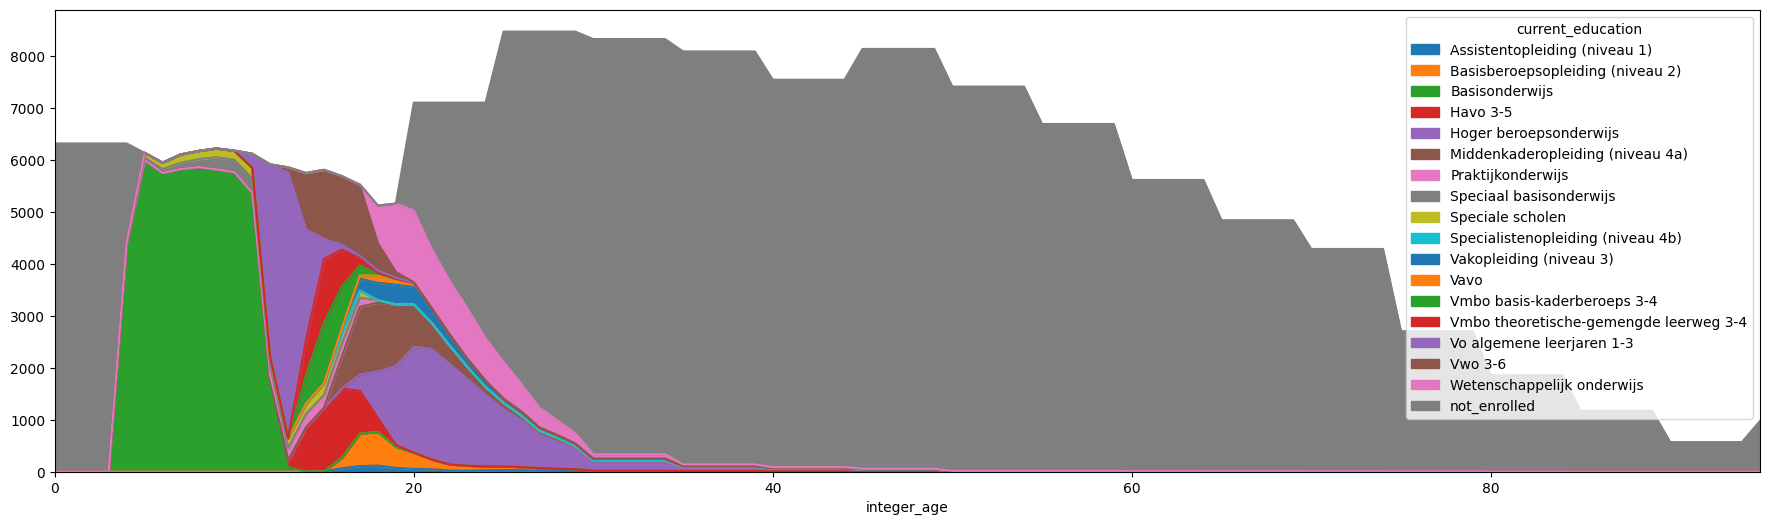

In [51]:
df_viz = df_edu_final_melted.groupby(
        ["age", "current_education"]).sum().reset_index()[["age", "current_education", "count"]]

df_viz.loc[:, "integer_age"] = df_viz.age.apply(transform_age)
df_viz = df_viz.explode(column='integer_age')
df_viz.loc[:, "count"] = df_viz.groupby(["age", "current_education"])["count"].transform(lambda x: x / len(x))
df_viz.drop('age', axis=1, inplace=True)
df_viz.sort_values(by='integer_age')
df_viz = df_viz.pivot(index=['integer_age'], columns='current_education', values='count')
df_viz.plot(kind='area', figsize=(22, 6))
plt.xlim([0, 95])

(0.0, 95.0)

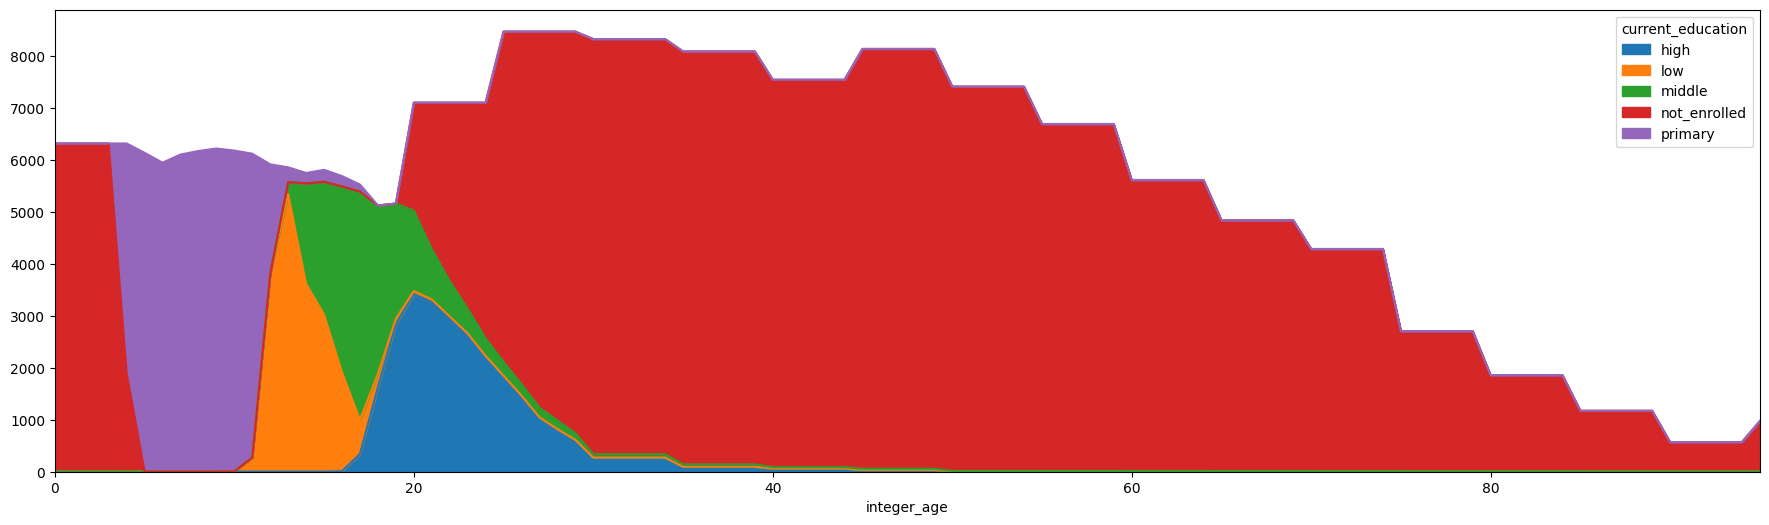

In [52]:
df_viz.reset_index().melt(id_vars=['integer_age']).replace(specific_to_grouped_education_map).groupby(
        ['integer_age', 'current_education']
).sum().reset_index().pivot(
        index="integer_age", columns='current_education', values='value'
).plot(kind="area", figsize=(22, 6))
plt.xlim([0, 95])

This perfectly demonstrates why above age 30, age groups are used.